# Topographic factor
<img src="images/LS_factor.png" style="width: 300px; float:right"><h>The topographic factor or **LS factor** in the RUSLE (Revised Universal Soil Loss Equation) represents the combined effect of **slope length (L) and slope steepness (S)** on soil erosion. It quantifies how topography influences the rate of soil loss by water runoff.
The **LS factor** represents the effect of:
- **L**: **Slope Length** → How far water can flow before it concentrates and erodes more
- **S**: **Slope Steepness** → How steep the slope is, influencing the velocity and erosive power of water

The two are calculated like this:
- **S** Factor (**Slope Steepness**):
  - If the slope is gentle (<9%), erosion grows slowly with slope.
  - If the slope is steeper (>9%), erosion increases much more rapidly.
  - Empirical formula (from **Foster et al., 1981**):
    
    $
    S = 
    \begin{cases}
    10.8 \times \sin(\text{slope}) + 0.03 & \text{if slope } < 9\% \\
    16.8 \times \sin(\text{slope}) - 0.50 & \text{if slope } \geq 9\%
    \end{cases}
    $


- **L** Factor (**Slope Length**):
  - Longer flow paths collect more water, leading to higher erosive force.
  - Calculated from **flow accumulation** (which counts how many cells drain into a given pixel).
  - A slope-dependent exponent `m` modifies the relationship, where:
    - Steeper slopes → smaller effect of slope length
    - Gentle slopes → larger effect of slope length
  - The exponent `m` is calculated from the **slope steepness**.

## First we need to import the necessary libraries and iMPACT-tools    
    
##### Import tools

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Dropdown  # For creating interactive widgets
# Import the necessary iMPACTools (you can find these tools in the Python files stored in the */iMPACtools* folder)
os.chdir('..') # change the current working directory to the parent directory
from iMPACTools.file_IO import open_raster, save_as_raster
from iMPACTools.plot_dem import plot3d_dem
from iMPACTools.dem_analysis import ls_factor

## Choose the case study

In [2]:
# Get list of case studies (folders in the Case_studies directory)
case_study = Dropdown(options=os.listdir('Case_studies'),description='Case Study:')
display(case_study)  

Dropdown(description='Case Study:', options=('Montefrio', 'SantaCruz'), value='Montefrio')

## Load slope and flow accumulation raster files
These files were previously obtained in the iMPACT Notebook **3.Flow_accumulation**

In [25]:
# --- Load DEM Raster ---
dem, metadata = open_raster(f'Case_studies/{case_study.value}/topo/','dem_catchment.tif')
cell_size = metadata['transform'][0]
# --- Load Slope Raster ---
slope, metadata = open_raster(f'Case_studies/{case_study.value}/topo/','slope.tif')
# --- Load Flow Accumulation Raster ---
flow_acc, metadata = open_raster(f'Case_studies/{case_study.value}/flow/','flow_acc_Dinf.tif')

## Function to compute the LS factor

In [26]:
# --- Function to Calculate LS Factor ---
def ls_factor(slope, flow_acc, cell_size):
    """
    Calculates the L (slope length), S (slope steepness), and LS (combined) factors
    from slope and flow accumulation rasters.

    Parameters:
    -----------
    slope : 2D array-like
        Slope raster values, expressed as rise/run (not degrees).
    flow_acc : 2D array-like
        Flow accumulation (number of upslope contributing cells).

    Returns:
    --------
    L : 2D array-like
        Slope length factor
    S : 2D array-like
        Slope steepness factor
    LS : 2D array-like
        Combined LS factor
    """

    # --- S Factor (Slope Steepness) ---
    # Convert slope to percentage
    slope_percent = slope * 100

    # Convert slope to radians for trigonometric calculations
    slope_radians = np.arctan(slope)  # slope = rise/run, arctan gives angle in radians

    # Apply Foster et al. (1981) equations for S factor
    S = np.where(
        slope_percent < 9,
        10.8 * np.sin(slope_radians) + 0.03,
        16.8 * np.sin(slope_radians) - 0.50)

    # --- L Factor (Slope Length) ---
    # Calculate slope-dependent coefficient beta
    beta = (np.sin(slope_radians) / 0.0896) / (0.56 + 3 * (np.sin(slope_radians))**0.8)

    # Calculate m exponent depending on slope steepness
    m = beta / (beta + 1)

    # Calculate L factor from flow accumulation
    # 22.13 m is the standard RUSLE unit plot length
    L = (flow_acc*cell_size**2 / 22.13) ** m

    # --- LS Factor ---
    LS = L * S  # Multiply L and S factors

    return L, S, LS

## Run the function and plot the results

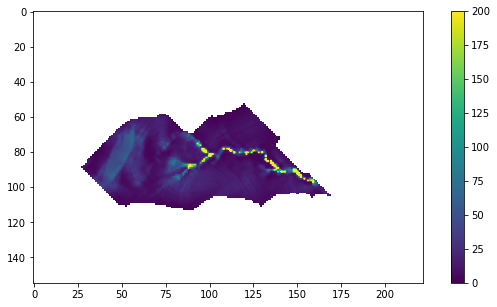

In [27]:
L,S,LS = ls_factor(slope, flow_acc, cell_size)
# Plot the LS factor map
plt.figure(figsize = (10,5))
plt.imshow(LS, vmin=0, vmax=200)
plt.colorbar()

### Apply stream/gully mask (optional)

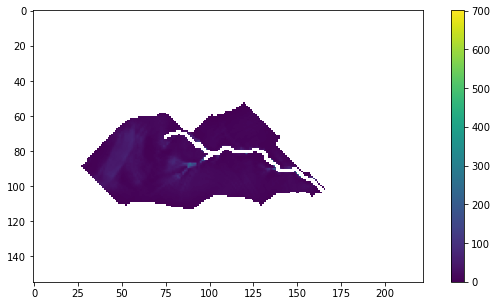

In [28]:
mask, metadata = open_raster(f'Case_studies/{case_study.value}/flow/','stream_mask_D8.tif')
LS[np.isnan(mask)] = np.nan
# Plot the LS factor map
plt.figure(figsize = (10,5))
plt.imshow(LS, vmin=0)
plt.colorbar()

<left><img src="images/save_raster.png" style="width: 100px; float:right"><h2>Save the results as a raster file</h2>

##### Save the LS-factor map

In [24]:
save_as_raster(f'Case_studies/{case_study.value}/topo/','LS_factor.tif', LS, metadata)